In [1]:
# Imported modules
import sys
sys.path.append("/mnt/raid-cita/dtolgay/FIRE/post_processing_fire_outputs")
from tools import constants

import pandas as pd 
import numpy as np 

import sys # To run the batch script

import os # To check if file exists.

from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt 

In [2]:
def h2_mass_fraction_calculator(
    local_density_scale_height, 
    density, 
    metallicity, 
    clumping_factor
):

    print("I am in the function h2_mass_fraction_calculator") 


    """This function is used to calculate the H2 mass fraction by using the formula 1 in the paper:
    A Comparison of Methods for Determining the Molecular Content of Model Galaxies by Krumholz, and Gnedin (2011)

    Arguments:
    ----------
    local_density_scale_height: array_like
        In this equation smooting length of the gas is assumed to be accurate estimation of the local density scale height. 
        Therefore smooting length is used instead of local density scale height
        [pc]

    density: array_like
        Density of the gas particles
        [gr / cm^3]

    metallicity: array_like
        metallicity of the gas particles 
        [Zsolar]

    clumping_factor: double or int
        It is a parameter to boost the h2 mass fraction and therefore h2 column density and CO luminosity
        [unitless]

    Returns:
    ----------
    h2_mass_fraction: array_like
        h2_mass_fraction = h2_gas_mass / total_gas_mass
        [unitless]

    column_density: array_like
        It is the column density considering all elements in the gas particle
        [gr/cm^2]

    dust_optical_depth: array_like  
        tau_c in the reference paper. It was being output in order to control the code
        [unitless]

    References: 
    -----------
    A Comparison of Methods for Determining the Molecular Content of Model Galaxies by Krumholz, and Gnedin (2011)

    """ 


    # The units of local_density_scale_height is kpc 
    local_density_scale_height = local_density_scale_height * constants.pc2cm  # [cm]

    # Calculation of column density 
    column_density = density * local_density_scale_height   # [gr / cm^2]
    # Column density is the summation sign in the paper
    # Gunjan assumed that local density scale height is same with the smoooting length of the gas particles. I will continue on this assumption
    # but I don't know how it works

    # Calculation of dust cross section (sigma_d in txhe paper)
    dust_cross_section_per_H_nucleus_normalized_to_1eminus21 = metallicity
    dust_cross_section = dust_cross_section_per_H_nucleus_normalized_to_1eminus21 * 1e-21   # [cm^2]


    # Calculation of dust optical depth (tau_c in the paper)
    # mu_h is the mean mass per H nucleus
    mu_h = 2.3e-24  # [gr] 
    # clumping factor is used to increase the H2 formation to account for density inhomogeneities that are unresolved on the computational grid
    # since the H2 formation rate varies as the square of density, these inhomogeneities increase the overall rate
    dust_optical_depth = column_density * dust_cross_section / mu_h     # [dimensionless]   

    # Calculation for scaled radiation field (chi in the paper) Eq 4 
    # This scaled radiation field will not likely to hold cell-by-cell every time step, but it should hold on average
    # clumping factor is used to boost the formation rate of the H2 molecules on dust grains (the R term)   
    scaled_radiation_field = 3.1 * (1 + 3.1 * metallicity**0.365) / (4.1 * clumping_factor)  # [dimensionless]

    # Calculation for s in the paper (Eq 2)
    s = np.log(1 + 0.6*scaled_radiation_field + 0.01 * np.power(scaled_radiation_field,2)) / ( 0.6 * dust_optical_depth )

    # Calculation for the H2 mass fraction (f_H2 in the paper Eq 1)
    h2_mass_fraction = 1 - (3/4) * (s / (1 + 0.25*s))   # [dimensionless]
    h2_mass_fraction[h2_mass_fraction < 0] = 0      # If the result is negative set it to zero
    
    # Set inf values to NaN
    # Replace inf/-inf with NaN
    h2_mass_fraction[np.isinf(h2_mass_fraction)] = np.nan
    column_density[np.isinf(column_density)] = np.nan    
    dust_optical_depth[np.isinf(dust_optical_depth)] = np.nan    
    scaled_radiation_field[np.isinf(scaled_radiation_field)] = np.nan    
    dust_optical_depth[np.isinf(dust_optical_depth)] = np.nan    
    
    return h2_mass_fraction, column_density, dust_optical_depth, scaled_radiation_field, s, dust_optical_depth



def X_co_calculator(
    h2_column_density, 
    metallicity, 
):
    print("I am in the function X_co_calculator")

    """This function is being used in order to calculate the X_co for each annulus

    Arguments:
    ----------
    h2_column_density: array-like
        h2_column_density for each particle 
        [gr/cm^2]

    metallicity: array-like
        [Zsolar]

    Returns:
    ----------
    X_co: vector 
        CO conversion factor for each particle
        [cm^-2 /K-km s^-1]
        
    X_co_solar_metallicity: vector
        X_co when metallicity is set to solar metallicity
        [cm^-2 /K-km s^-1]

    References: 
    -----------
    A general model for the CO-H2 conversion factor in galaxies with applications to the star formation law. (Narayanan et al. 2012)

    """ 


    h2_column_density = h2_column_density * constants.gr2M_sun / (constants.cm2pc)**2   
    # h2_column_density [M_sun/pc^2]

    # A general model for the CO-H2 conversion factor in galaxies with applications to the star formation law. (Narayanan et al. 2012)
    # Eq 6 

    X_co = 1.3e21/(metallicity * h2_column_density**0.5) #[cm^-2 /K-km s^-1]

    ####    

    X_co_solar_metallicity = 1.3e21/(constants.solar_metallicity * h2_column_density**0.5) #[cm^-2 /K-km s^-1]

    # Set inf values to NaN
    # Replace inf/-inf with NaN
    X_co[np.isinf(X_co)] = np.nan
    X_co_solar_metallicity[np.isinf(X_co_solar_metallicity)] = np.nan
    
    
    return X_co, X_co_solar_metallicity



In [3]:
# galaxy_name = "gal20"
# galaxy_type = "firebox"
# redshift = "3.0"

galaxy_name = "m12i_res7100_md"
galaxy_type = "zoom_in"
redshift = "3.0"

# Read cloudy_gas_txt 
run_dir = "voronoi_1e6"
cloudy_gas_particles_file_directory = f"/mnt/raid-cita/dtolgay/FIRE/post_processing_fire_outputs/skirt/runs_hden_radius/{galaxy_type}/z{redshift}/{galaxy_name}/{run_dir}" 

cloudy_gas_particles_file_directory

'/mnt/raid-cita/dtolgay/FIRE/post_processing_fire_outputs/skirt/runs_hden_radius/zoom_in/z3.0/m12i_res7100_md/voronoi_1e6'

In [4]:
# Define the column names based on your description
gas_column_names = [
    "x", 
    "y", 
    "z", 
    "smoothing_length", 
    "mass", 
    "metallicity", # Zsolar but will be converted to mass fraction in the future
    "temperature", 
    "vx", 
    "vy", 
    "vz", 
    "hden", 
    "radius", 
    "sfr", 
    "turbulence", 
    "density", 
    "mu_theoretical", 
    "average_sobolev_smoothingLength",
    "index", 
    "isrf"
]


gas_particles_df = pd.read_csv(
    f"{cloudy_gas_particles_file_directory}/cloudy_gas_particles.txt",
    delim_whitespace=True, 
    comment='#', 
    names=gas_column_names
)


In [5]:
# hden_condition = gas_particles_df['density'] / (constants.proton_mass * constants.kg2g * constants.mu_h) >= 1e3


# bins = np.linspace(start=-3, stop=4, num=100)
# plt.hist(np.log10(gas_particles_df['hden']), bins=bins)
# plt.hist(np.log10(gas_particles_df[hden_condition]['hden']), bins=bins)
# plt.show()


# bins = np.linspace(start=0, stop=0.4, num=100)
# plt.hist(gas_particles_df['sfr'], bins=bins)
# plt.hist(gas_particles_df[hden_condition]['sfr'], bins=bins)
# plt.yscale("log")
# plt.show()



# f_H2

In [6]:
h2_mass_fraction, gas_column_density, dust_optical_depth, scaled_radiation_field, s, dust_optical_depth = h2_mass_fraction_calculator(
    local_density_scale_height = np.array(gas_particles_df["average_sobolev_smoothingLength"]), # pc
    density = np.array(gas_particles_df["density"]), # gr / cm^3
    metallicity= np.array(gas_particles_df["metallicity"]),  # Zsolar
    clumping_factor = 1
)
gas_particles_df["fh2"] = h2_mass_fraction
gas_particles_df["Mh2"] = gas_particles_df["mass"] * gas_particles_df["fh2"]



I am in the function h2_mass_fraction_calculator


In [7]:
gunjan_fh2 = np.loadtxt("gunjan/gunjan_m12i_res7100_md_fh2.txt")

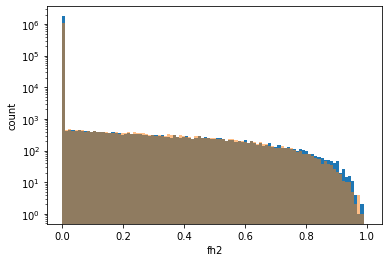

In [8]:
bins = np.linspace(0,1,100)
plt.hist(h2_mass_fraction, bins=bins)
plt.hist(gunjan_fh2, bins=bins, alpha=0.5)
plt.xlabel("fh2")
plt.ylabel("count")
plt.yscale("log")
plt.show()


# bins = np.linspace(0.5,4,100)
# plt.hist(np.log10(gas_particles_df["smoothing_length"]), bins=bins)
# plt.xlabel("smoothing_length log10(pc)")
# plt.ylabel("count")
# plt.yscale("log")
# plt.show()


# plt.hist(dust_optical_depth)
# plt.xlabel("optical depth")
# plt.ylabel("count")
# plt.yscale("log")
# plt.show()



In [9]:

len(gunjan_fh2) < len(h2_mass_fraction)

True

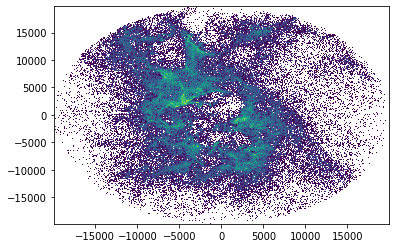

In [10]:
plt.hist2d(
    x = gas_particles_df["x"], 
    y = gas_particles_df["y"], 
    bins = 1024, 
    norm = LogNorm()
)
plt.show()

In [11]:
total_sfr = sum(gas_particles_df['sfr'])
print(f"Total sfr: {np.round(total_sfr, 2)} Msolar / year")

total_gas_mass = sum(gas_particles_df['mass'])
print(f"Total gas mass: {np.round(total_gas_mass/1e9, 2)} E9")

total_h2_mass = sum(gas_particles_df['Mh2'])
print(f"Total H2 mass: {np.round(total_h2_mass/1e9, 4)} E9")

Total sfr: 2.5 Msolar / year
Total gas mass: 12.81 E9
Total H2 mass: 0.0561 E9


# Lco

In [12]:
# Findind the column density of gas particles. 
h2_column_density = h2_mass_fraction * gas_column_density  # [gr/cm^2]  

# Estimating the Xco of gas particles. 
gas_particles_df["Xco"], Xco_solar_metallicity = X_co_calculator(
    h2_column_density = h2_column_density,  # [gr / cm^2]
    metallicity = np.array(gas_particles_df["metallicity"]), # Zsolar
)    

# Calculating Lco
alfa_co = gas_particles_df["Xco"] / 6.3e19 # [M_solar/pc^-2 (K-km s^-1)^-1]

gas_particles_df["L_co"] = gas_particles_df["Mh2"] / alfa_co 

I am in the function X_co_calculator


/tmp/ipykernel_819084/2680780330.py:139: RuntimeWarning: divide by zero encountered in true_divide
  X_co = 1.3e21/(metallicity * h2_column_density**0.5) #[cm^-2 /K-km s^-1]
/tmp/ipykernel_819084/2680780330.py:143: RuntimeWarning: divide by zero encountered in true_divide
  X_co_solar_metallicity = 1.3e21/(constants.solar_metallicity * h2_column_density**0.5) #[cm^-2 /K-km s^-1]


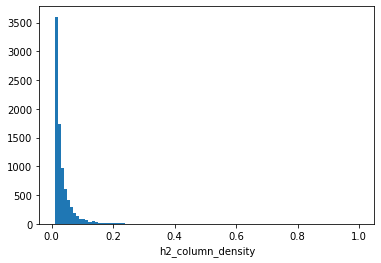

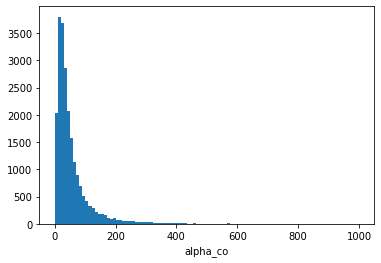

In [21]:
plt.hist(h2_column_density, bins=np.linspace(1e-2, 1, 100))
plt.xlabel("h2_column_density")
plt.show()

plt.hist(alfa_co, bins=np.linspace(0, 1000, 100))
plt.xlabel("alpha_co")
plt.show()

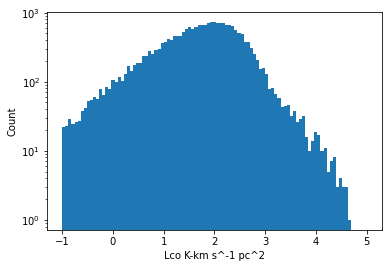

In [13]:
bins=np.linspace(-1, 5, 100)
plt.hist(np.log10(gas_particles_df["L_co"]), bins=bins)
plt.xlabel("Lco K-km s^-1 pc^2")
plt.ylabel("Count")
plt.yscale("log")
plt.show()

In [14]:
Lco_max_bins = np.linspace(-70, 4, num=75)

total_Lco = np.sum(gas_particles_df["L_co"])
print(f"total_Lco: {total_Lco}")

for lco_max in Lco_max_bins:
    condition = np.log10(gas_particles_df["L_co"]) < lco_max
    summed_Lco = np.sum(gas_particles_df[condition]["L_co"])
    percentage_Lco = summed_Lco / total_Lco * 100
    
    non_nan_count = gas_particles_df[condition]["L_co"].notna().sum()
    percantage_of_gas_particles_used = non_nan_count / len(gas_particles_df) * 100
    
    print(f"max Lco: {lco_max} ---- percentage Lco: {np.round(percentage_Lco,2)}% -- percantage_of_gas_particles: {np.round(percantage_of_gas_particles_used,2 )}%")
    

total_Lco: 6120478.635923527
max Lco: -70.0 ---- percentage Lco: 0.0% -- percantage_of_gas_particles: 0.0%
max Lco: -69.0 ---- percentage Lco: 0.0% -- percantage_of_gas_particles: 0.0%
max Lco: -68.0 ---- percentage Lco: 0.0% -- percantage_of_gas_particles: 0.0%
max Lco: -67.0 ---- percentage Lco: 0.0% -- percantage_of_gas_particles: 0.0%
max Lco: -66.0 ---- percentage Lco: 0.0% -- percantage_of_gas_particles: 0.0%
max Lco: -65.0 ---- percentage Lco: 0.0% -- percantage_of_gas_particles: 0.0%
max Lco: -64.0 ---- percentage Lco: 0.0% -- percantage_of_gas_particles: 0.0%
max Lco: -63.0 ---- percentage Lco: 0.0% -- percantage_of_gas_particles: 0.0%
max Lco: -62.0 ---- percentage Lco: 0.0% -- percantage_of_gas_particles: 0.0%
max Lco: -61.0 ---- percentage Lco: 0.0% -- percantage_of_gas_particles: 0.0%
max Lco: -60.0 ---- percentage Lco: 0.0% -- percantage_of_gas_particles: 0.0%
max Lco: -59.0 ---- percentage Lco: 0.0% -- percantage_of_gas_particles: 0.0%
max Lco: -58.0 ---- percentage Lco:

In [15]:
non_nan_count = gas_particles_df["L_co"].notna().sum()
print(non_nan_count)


22200


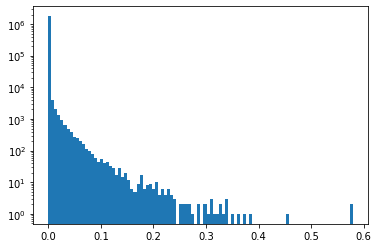

In [16]:
plt.hist(h2_column_density, bins=100)
plt.yscale("log")
plt.show()